# Reverse Image Search
Reverse image search is a technique which enables us to go beyond the typical keyword-based text search engines. From discovering similar products on e-commerce websites to identifying duplicate photographs and a number of other such user-cases are enabled using reverse-image search techniques. Websites such as Amazon, Pinterest, etc. and software such as Google Photos, Adobe Lightroom are real-world examples where such techniques are leveraged.

In this notebook, we will leverage pre-trained CNNs to extract features and perform image search on Caltech-101 dataset

## Get the dataset

- Caltech-101 dataset official website:[website](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)
- Download link : [google-drive](https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp)

In [1]:
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
!tar -xvzf 101_ObjectCategories.tar.gz 

Streaming output truncated to the last 5000 lines.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chai

## Import required Libraries

In [2]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.26-cp36-none-any.whl size=6516 sha256=c4700f31b246b833065bcc6b675c3aca274e3c691481b96a4523ffc736a8fc12
  Stored in directory: /root/.cache/pip/wheels/f5/6f/f1/84c54c13581bfe1ea75ff56743cb31707f552eabe682e9714a
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.23-cp36-none-any.whl size=6987 sha256=1f01939dae73db22e9bbefb21107e3ef0fec9c1c73422923869dc9088292cb6b
  Stored in directory: /root/.cache/pip/wheels/d2/b5/7d/a51cd1ac4ee246a7b59bcea6b37e768d9976ca5aa5918e7cd9
  Created wheel for compress-json: filename=compress_json-1.0.4-cp36-none-any.whl size=4585 sha256=dfe77f0775ebe3a282c1924edbb3fdff9ca09392bbdc3492949fb4f2987c91cf
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [3]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [4]:
tf.__version__

'2.4.0'

In [5]:
def get_pretrained_model(name):
    if (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    else:
        print("Specified model not available")
    return model

In [6]:
model_architecture = 'resnet'
model = get_pretrained_model(model_architecture)

94773248/94765736 [==============================] - 1s 0us/step


## Utility function to Extract Features from Pretrained CNN

In [7]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

## Transform Images to Feature Vectors

In [8]:
# test on sample image
features = extract_features('101_ObjectCategories/Faces/image_0003.jpg', model)
print(len(features))

2048


In [9]:
features

array([0.01047899, 0.00874928, 0.00522772, ..., 0.01031556, 0.00714269,
       0.01710161], dtype=float32)

In [16]:
# transform whole dataset
batch_size = 64
root_dir = '101_ObjectCategories/'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
feature_list = model.predict(generator, num_epochs)
end_time = time.time()

Found 9144 images belonging to 102 classes.


In [17]:
# Optional Step: normalize feature vectors
for i, features in tqdm(enumerate(feature_list)):
    feature_list[i] = features / norm(features)

9144it [00:00, 106265.82it/s]


In [18]:
print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  9144
Shape of feature_list =  (9144, 2048)
Time taken in sec =  30.343070030212402


## Persist Objects

In [19]:
filenames = [root_dir + '/' + s for s in generator.filenames]

In [20]:
pickle.dump(generator.classes, open('resnet_101_classes.pickle','wb'))
pickle.dump(filenames, open('resnet_101_files.pickle', 'wb'))
pickle.dump(feature_list,open('resnet_101_features.pickle', 'wb'))

# Cosine Similarity Search

In [21]:
from sklearn.metrics.pairwise import pairwise_distances

In [22]:
from sklearn.manifold import TSNE
import PIL
from PIL import Image

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Utilities to Visualize Results

In [23]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]), fontsize=20)
        else:
            ax.set_title(classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))), fontsize=20)
        plt.imshow(image)
        plt.axis("off")

In [24]:
# Calculate pair-wise distances
cosine_sim = 1-pairwise_distances(feature_list, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.6238491 , 0.41208124, 0.5756648 ],
       [0.6238491 , 1.        , 0.39770573, 0.48832983],
       [0.41208124, 0.39770573, 1.        , 0.38366008],
       [0.5756648 , 0.48832983, 0.38366008, 1.        ]], dtype=float32)

In [25]:
cosine_sim.shape

(9144, 9144)

In [26]:
# Function to find similar items based on cosine similarity
def find_similar_items(idx, top_n = 5):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return idx_rec,idx_sim

In [27]:
random_image_index = 1204
idx_rec, idx_sim = find_similar_items(random_image_index, top_n = 6)

In [28]:
similar_image_paths = [filenames[random_image_index]] + \
                        [filenames[i] for i in idx_rec]

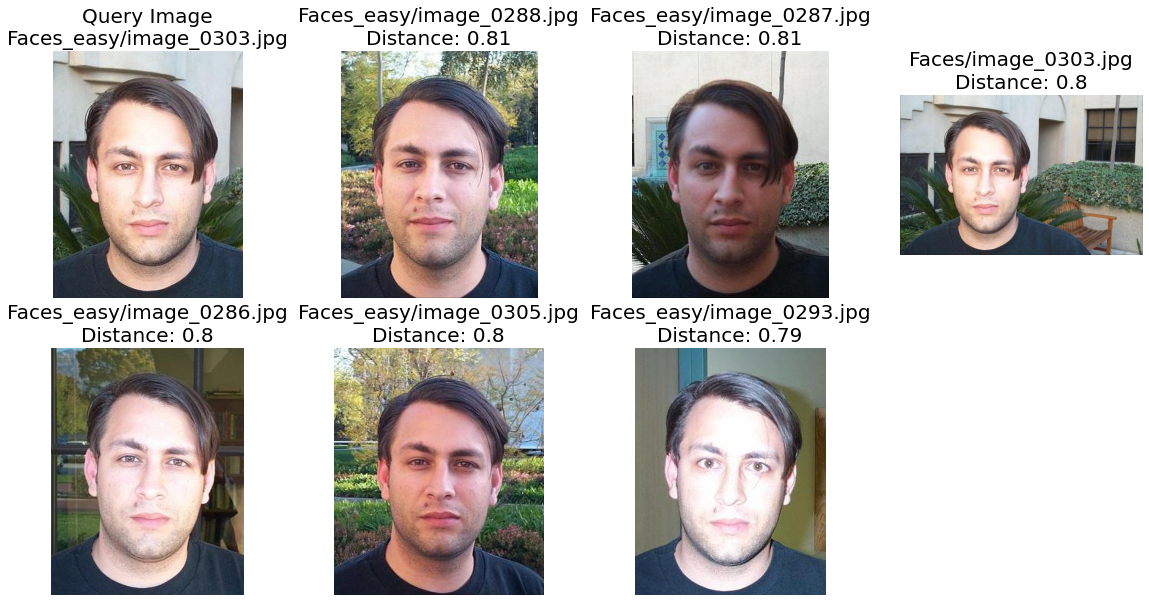

In [29]:
plot_images(similar_image_paths, [0]+idx_sim)

In [40]:
# visualize for a larger sample
for i in range(6):
    random_image_index = random.randint(0, num_images)
    idx_rec, idx_sim = find_similar_items(random_image_index, top_n = 3)
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
                        [filenames[i] for i in idx_rec]
    plot_images(similar_image_paths, [0]+idx_sim)

Output hidden; open in https://colab.research.google.com to view.

# KNN Based Similarity Search

In [32]:
from sklearn.neighbors import NearestNeighbors

## Fit a simple KNN
- Use image vectors as input feature list

In [33]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

## Visualize Results

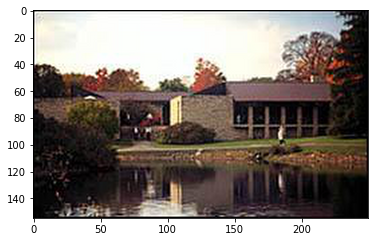

In [34]:
# test for a random index
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

In [39]:
# visualize for a larger sample
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning: Fine-Tuning on custom dataset

In [ ]:
def get_model(img_width, img_height):
    base_model = ResNet50(include_top=False,
                           input_shape=(img_width, img_height, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(img_width, img_height, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

### Set Training Parameters

In [ ]:
TRAIN_SAMPLES = 9144
NUM_CLASSES = 102 # One additional label for unknown class
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 9144 images belonging to 102 classes.


## Begin Fine-Tuning

In [ ]:
model_finetuned = get_model(IMG_WIDTH, IMG_HEIGHT)
model_finetuned.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history = model_finetuned.fit(
                              train_generator,
                              steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
                              epochs=25)

Epoch 1/25
143/143 [==============================] - 106s 742ms/step - loss: 3.0170 - acc: 0.3407
Epoch 2/25
143/143 [==============================] - 106s 740ms/step - loss: 1.8235 - acc: 0.5522
Epoch 3/25
143/143 [==============================] - 106s 739ms/step - loss: 1.4118 - acc: 0.6307
Epoch 4/25
143/143 [==============================] - 106s 740ms/step - loss: 1.2152 - acc: 0.6680
Epoch 5/25
143/143 [==============================] - 106s 740ms/step - loss: 1.0835 - acc: 0.7067
Epoch 6/25
143/143 [==============================] - 106s 739ms/step - loss: 0.9993 - acc: 0.7205
Epoch 7/25
143/143 [==============================] - 105s 737ms/step - loss: 0.9295 - acc: 0.7345
Epoch 8/25
143/143 [==============================] - 105s 737ms/step - loss: 0.9032 - acc: 0.7430
Epoch 9/25
143/143 [==============================] - 105s 737ms/step - loss: 0.8434 - acc: 0.7533
Epoch 10/25
143/143 [==============================] - 106s 739ms/step - loss: 0.8001 - acc: 0.7642
Epoch 11/

In [ ]:
from plot_keras_history import plot_history

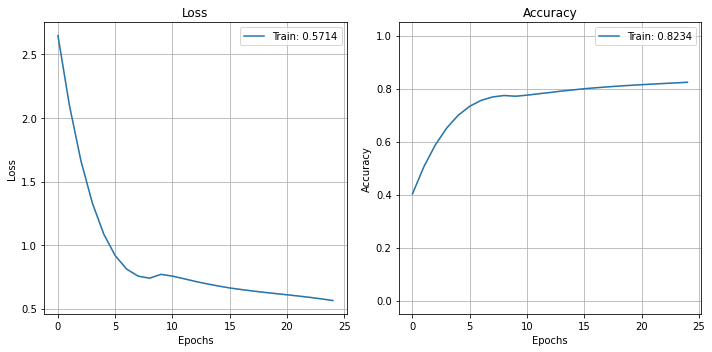

In [ ]:
plot_history(history.history,  interpolate=True)
plt.show()
plt.close()

## Get Feature Extraction Model

In [ ]:
#model_finetuned.layers.pop()
model_similarity = Model(model_finetuned.input,model_finetuned.layers[-4].output)

In [ ]:
model_similarity.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


## Get Features

In [ ]:
start_time = time.time()
feature_list_finetuned = []
feature_list_finetuned = model_similarity.predict(generator, num_epochs)
end_time = time.time()

for i, features_finetuned in enumerate(feature_list_finetuned):
    feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

feature_list_finetuned = feature_list_finetuned.reshape(num_images, -1)

print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list_finetuned.shape)
print("Time taken in sec = ", end_time - start_time)

Instructions for updating:
Please use Model.predict, which supports generators.
Num images   =  9144
Shape of feature_list =  (9144, 2048)
Time taken in sec =  30.346380710601807


## Persist Objects

In [ ]:
pickle.dump(generator.classes, open('resnet_finetuned_101_classes.pickle','wb'))
pickle.dump(feature_list_finetuned,open('resnet_finetuned_101_features.pickle', 'wb'))

## KNN Based Similarity Search using Finetuned model

In [ ]:
ft_neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list_finetuned)

## Visualize Results

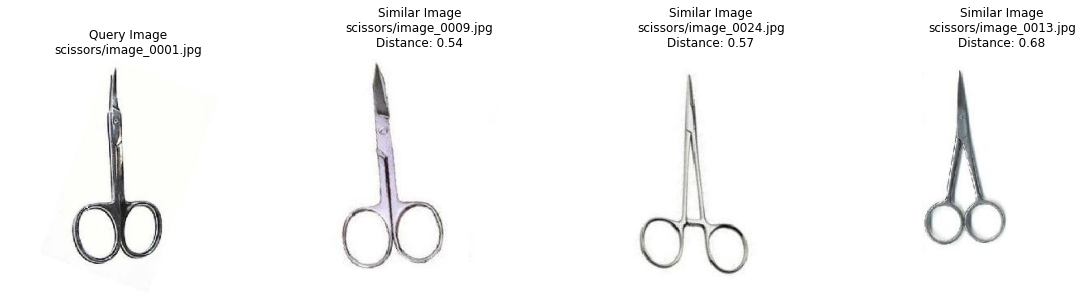

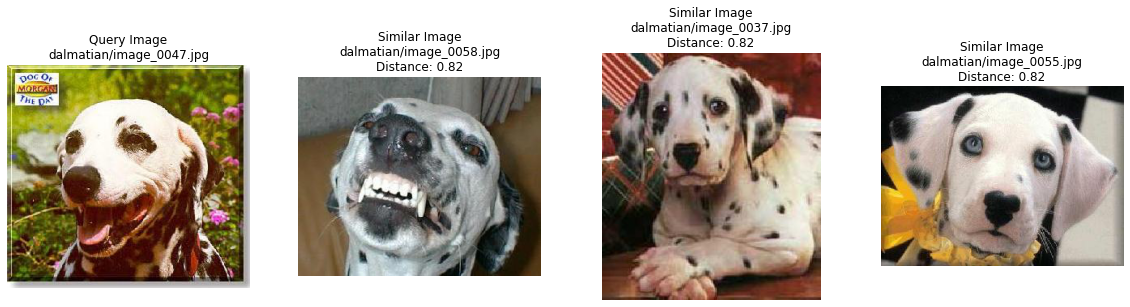

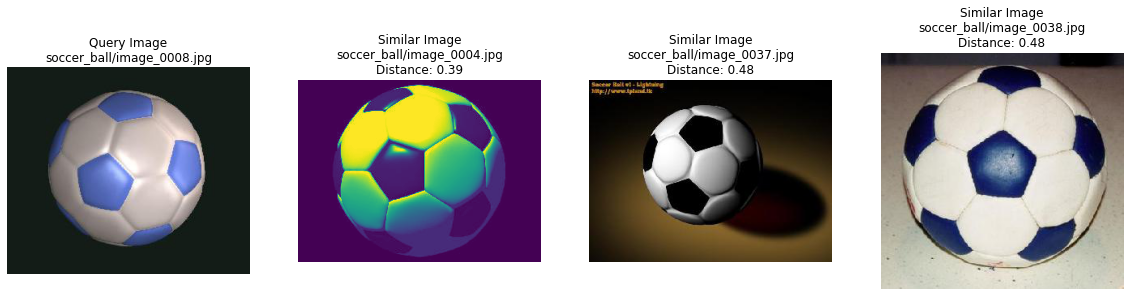

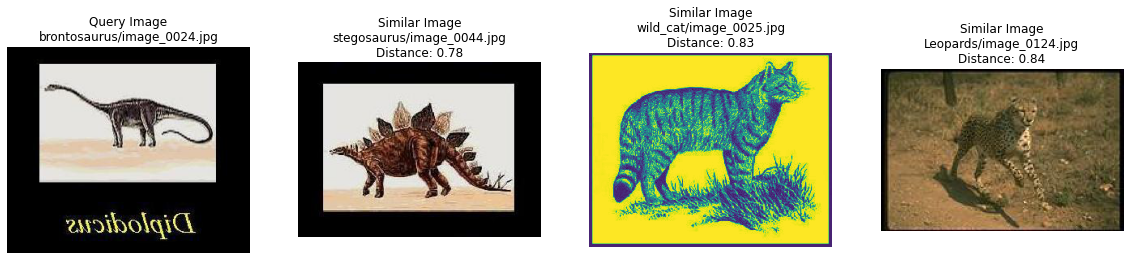

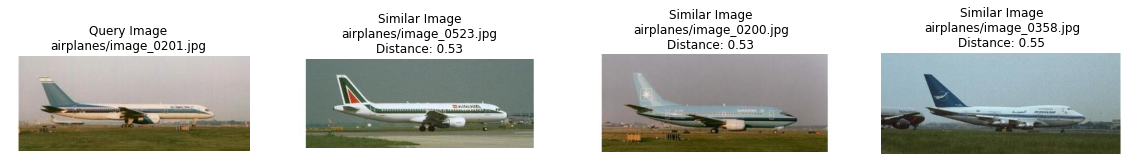

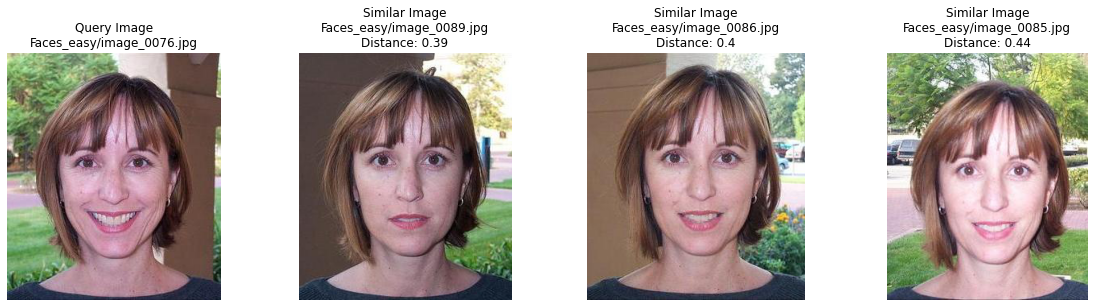

In [ ]:
# visualize for a larger sample
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = ft_neighbors.kneighbors(
        [feature_list_finetuned[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

# Optimized Nearest Neighbor Search

+ There are a number of higly optimized implementations available, such as NGT, Annoy, FAISS, etc.
+ In this section we will test out the performance of Annoy

## Install Annoy

In [ ]:
!pip3 install annoy

     |████████████████████████████████| 655kB 8.2MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp36-cp36m-linux_x86_64.whl size=390344 sha256=445587f44c01c77d158ba7ad7c4845718e57b0f23eac500694e0116a5b4bb64c
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex

### Prepare Annoy Index

In [ ]:
annoy_index = AnnoyIndex(2048,'angular')  

# add features to annoy_index
for i in range(num_images):
    feature = feature_list[i]
    annoy_index.add_item(i, feature)

2.3489723205566406


In [ ]:
# build and persist annoy tree object
annoy_index.build(40)
annoy_index.save('annoy_caltech101index.ann')

True

## Test Annoy's Performance

In [ ]:
random_image_index = random.randint(0, num_images)

In [ ]:
# single image test
annoy_index = AnnoyIndex(2048,'angular')
annoy_index.load('annoy_caltech101index.ann')

1000 loops, best of 3: 770 µs per loop


In [ ]:
# test search performance
%timeit annoy_index.get_nns_by_vector(feature_list[random_image_index], 5, include_distances=True)

In [ ]:
# get similar indices
indexes = annoy_index.get_nns_by_vector(feature_list[random_image_index],
                              5,
                              include_distances=True)

In [ ]:
# test on a larger sample
def calculate_annoy_time():
    for i in range(0, 100):
      random_image_index = random.randint(0, num_images)
      indexes = annoy_index.get_nns_by_vector(feature_list[random_image_index],
                                              5,
                                              include_distances=True)

In [ ]:
%time calculate_annoy_time()

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 142 ms


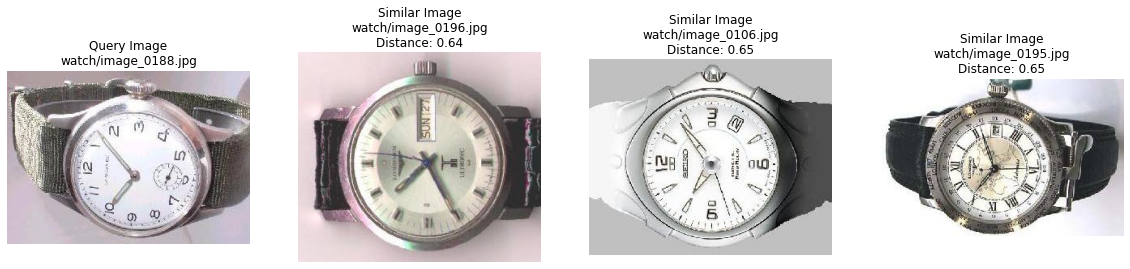

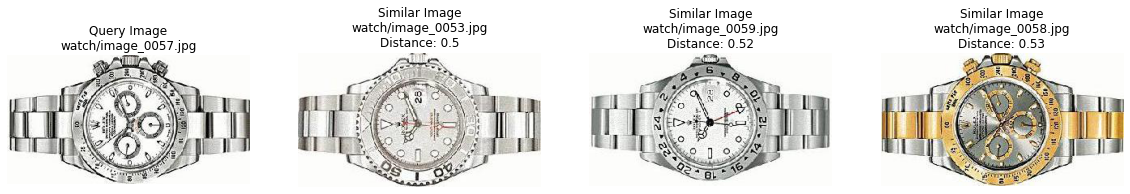

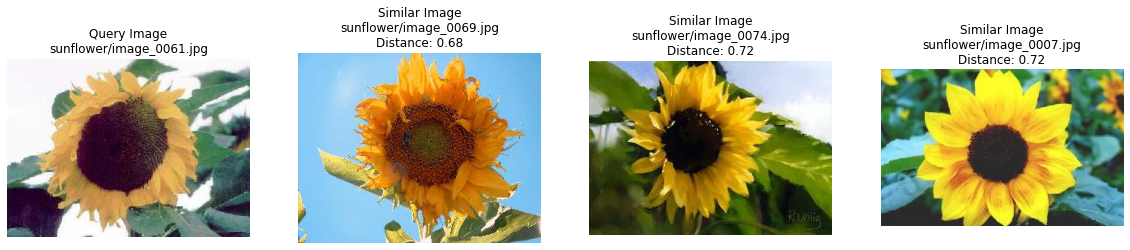

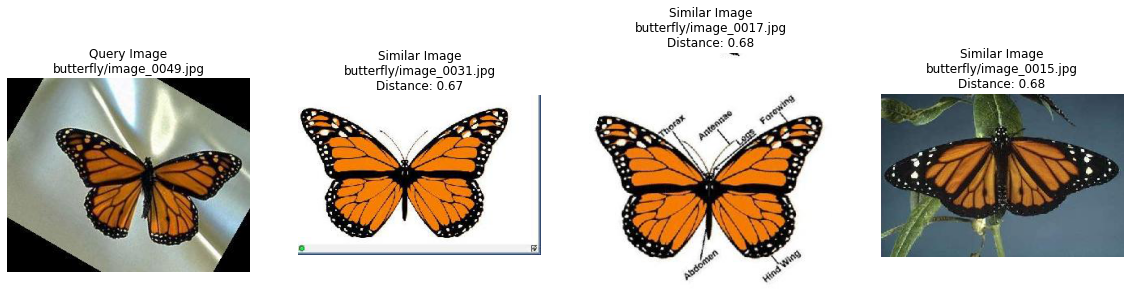

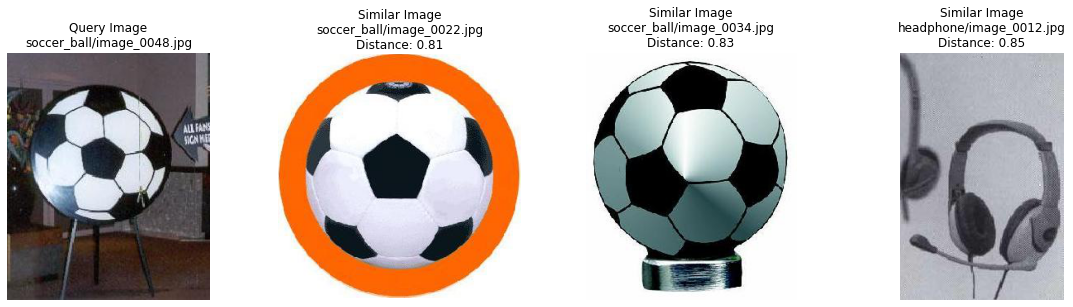

In [ ]:
# visualize annoy outputs
for i in range(0, 5):
  random_image_index = random.randint(0, num_images)
  indexes = u.get_nns_by_vector(feature_list[random_image_index],
                                  5,
                                  include_distances=True)
  similar_image_paths = [filenames[random_image_index]] + \
    [filenames[indexes[0][i]] for i in range(1, 4)]
  plot_images(similar_image_paths, indexes[1])